# NAWI Alliance Spring Meeting 2023: 
# Interactive Code Demonstration Using WaterTAP

### Today's demonstration will show 
- Part 1: how to build, initialize, simulate, and optimize a nanofiltration (NF) unit model based on the Donnan Steric Pore Model with Dielectric Exclusion (DSPM-DE).
- Part 2: repeat the same process for an NF flowsheet with bypass.
- Part 3: demonstrate the same NF flowsheet in WaterTAP's graphical user interface, which is in early stages of development.

# Part 1: Build, setup, simulate, and optimize the NF DSPM-DE unit model

<img src="nf_dspmde_transport_mechanisms.png" width="500" height="340">
Image source: <a href="https://doi.org/10.1016/j.desal.2017.07.020">Roy et al., 2017</a>


<img src="nf_ui.png" width="500" height="340">

## Step 1: Import libraries from Pyomo, IDAES, and WaterTAP.

In [166]:
# Imports from Pyomo, including "value" for getting the value of Pyomo objects
from pyomo.environ import ConcreteModel, Constraint, Objective, Expression, value, units as pyunits, assert_optimal_termination

# Imports from IDAES:
# Import flowsheet block from IDAES core
from idaes.core import FlowsheetBlock

# Import function to get default solver
from idaes.core.solvers import get_solver

# Import function to check degrees of freedom
from idaes.core.util.model_statistics import degrees_of_freedom

# Import utility function for calculating scaling factors
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor

# Import IDAES units
from idaes.models.unit_models import Feed, Product

import idaes.logger as idaeslog
_log = idaeslog.getLogger(__name__)


### WaterTAP Imports: 
* multicomponent property model
* pump
* NF DSPM-DE unit model
* configuration options can be used to change underlying model assumptions

In [167]:
# Imports from WaterTAP
# Import MultiComponent Aqueous Solution property model
from watertap.property_models.multicomp_aq_sol_prop_pack import (MCASParameterBlock, 
                                                                 ActivityCoefficientModel,
                                                                 DensityCalculation,)
# Import pump model
from watertap.unit_models.pressure_changer import Pump

# Import NF DSPM-DE model
from watertap.unit_models.nanofiltration_DSPMDE_0D import (
    NanofiltrationDSPMDE0D,
    MassTransferCoefficient,
    ConcentrationPolarizationType,
)

## Step 2: Start building the NF DSPM-DE model.

In [168]:
# Create a Pyomo concrete model, flowsheet, and set up solute properties required by the DSPM-DE model.
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

property_kwds = {
"solute_list": [
    "Ca_2+",
    "SO4_2-",
    "HCO3_-",
    "Na_+",
    "Cl_-",
],
"diffusivity_data": {
    ("Liq", "Ca_2+"): 9.2e-10,
    ("Liq", "SO4_2-"): 1.06e-9,
    ("Liq", "HCO3_-"): 1.19e-9,
    ("Liq", "Na_+"): 1.33e-9,
    ("Liq", "Cl_-"): 2.03e-9,
},
"mw_data": {
    "H2O": 18e-3,
    "Ca_2+": 40e-3,
    "HCO3_-": 61.0168e-3,
    "SO4_2-": 96e-3,
    "Na_+": 23e-3,
    "Cl_-": 35e-3,
},
"stokes_radius_data": {
    "Ca_2+": 0.309e-9,
    "HCO3_-": 2.06e-10,
    "SO4_2-": 0.230e-9,
    "Cl_-": 0.121e-9,
    "Na_+": 0.184e-9,
},
"charge": {
    "Ca_2+": 2,
    "HCO3_-": -1,
    "SO4_2-": -2,
    "Na_+": 1,
    "Cl_-": -1,
},
"activity_coefficient_model": ActivityCoefficientModel.ideal,
"density_calculation": DensityCalculation.constant,
}

m.fs.properties = MCASParameterBlock(**property_kwds)

### Add a feed, product, and disposal blocks
* Feed for inlet composition
* Product for NF permeate
* Disposal for NF concentrate

In [169]:
m.fs.feed = Feed(property_package=m.fs.properties)
m.fs.product = Product(property_package=m.fs.properties)
m.fs.disposal = Product(property_package=m.fs.properties)

### Add a pump and an NF DSPM-DE unit to the flowsheet.

In [170]:
m.fs.pump = Pump(property_package=m.fs.properties)
m.fs.unit = NanofiltrationDSPMDE0D(property_package=m.fs.properties)

## Step 3: Specify values for system variables.

### Fix inlet state variables 
* mole flow rates of each component
* temperature
* pressure

In [171]:
degrees_of_freedom(m.fs.feed)

0

In [172]:
m.fs.feed.properties[0].temperature.fix(298.15)
m.fs.feed.properties[0].pressure.fix(4e5)

feed_mass_frac = {
    "Ca_2+": 4.0034374454637006e-04,
    "HCO3_-": 0.00022696833343821863,
    "SO4_2-": 0.00020497140244420624,
    "Cl_-": 0.0004559124032433401,
    "Na_+": 0.00043333830389924205,
}
H2O_mass_frac = 1 - sum(x for x in feed_mass_frac.values())
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e4, index=("Liq", "Ca_2+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e3, index=("Liq", "SO4_2-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e3, index=("Liq", "HCO3_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e2, index=("Liq", "Cl_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e2, index=("Liq", "Na_+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e0, index=("Liq", "H2O"))

m.fs.feed.properties[0].mass_frac_phase_comp
m.fs.feed.properties[0].conc_mol_phase_comp
m.fs.feed.properties[0].conc_mass_phase_comp
m.fs.feed.properties[0].flow_vol_phase
calculate_scaling_factors(m.fs.feed.properties[0])
m.fs.feed.properties.calculate_state(
    var_args={
        ("mass_frac_phase_comp", ("Liq", "Ca_2+")): 4.0034374454637006e-04,
        ("mass_frac_phase_comp", ("Liq", "HCO3_-")): 0.00022696833343821863,
        ("mass_frac_phase_comp", ("Liq", "SO4_2-")): 0.00020497140244420624,
        ("mass_frac_phase_comp", ("Liq", "Cl_-")): 0.0004559124032433401,
        ("mass_frac_phase_comp", ("Liq", "Na_+")): 0.00043333830389924205,
        ("flow_vol_phase", "Liq"): 1e-3,  

    },  
    hold_state=True)


2023-05-24 04:34:57 [WARNING] idaes.watertap.property_models.multicomp_aq_sol_prop_pack: While using the calculate_state method on fs.feed.properties[0.0], variable mass_frac_phase_comp was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand after the scaling factors were calculated. It is recommended to touch all relevant variables (i.e. call them or set an initial value) before using the calculate_scaling_factor method.
2023-05-24 04:34:57 [WARNING] idaes.watertap.property_models.multicomp_aq_sol_prop_pack: While using the calculate_state method on fs.feed.properties[0.0], variable mass_frac_phase_comp was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand after the scaling factors were calculated. It is recommended t

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 26, 'Number of variables': 26, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.08046579360961914}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [176]:
mass_flow_in = 1 * pyunits.kg / pyunits.s
feed_mass_frac = {
    "Ca_2+": 4.0034374454637006e-04,
    "HCO3_-": 0.00022696833343821863,
    "SO4_2-": 0.00020497140244420624,
    "Cl_-": 0.0004559124032433401,
    "Na_+": 0.00043333830389924205,
}

for ion, x in feed_mass_frac.items():
    mol_comp_flow = (x*mass_flow_in
                     / m.fs.unit.feed_side.properties_in[0].mw_comp[ion])
    m.fs.unit.inlet.flow_mol_phase_comp[0, "Liq", ion].fix(mol_comp_flow)
    
H2O_mass_frac = 1 - sum(x for x in feed_mass_frac.values())
H2O_mol_comp_flow = (H2O_mass_frac* mass_flow_in
                     /m.fs.unit.feed_side.properties_in[0].mw_comp["H2O"])
m.fs.unit.inlet.flow_mol_phase_comp[0, "Liq", "H2O"].fix(H2O_mol_comp_flow)

In [177]:
for j in m.fs.properties.component_list:
    print(f"{j}= {value(m.fs.feed.properties[0].flow_mol_phase_comp['Liq', j])}")

H2O= 55.45991476735715
Ca_2+= 0.010008593613659252
SO4_2-= 0.002135118775460484
HCO3_-= 0.003719767890781208
Na_+= 0.018840795821706183
Cl_-= 0.01302606866409544


In [178]:
for j in m.fs.properties.component_list:
    print(f"{j}= {value(m.fs.unit.inlet.flow_mol_phase_comp[0, 'Liq', j])}")

H2O= 55.45991476735715
Ca_2+= 0.010008593613659252
SO4_2-= 0.0021351187754604815
HCO3_-= 0.003719767890781205
Na_+= 0.018840795821706176
Cl_-= 0.01302606866409543


### Use assert_electroneutrality method from property model to ensure the ion concentrations provided obey electroneutrality condition

In [179]:
m.fs.unit.feed_side.properties_in[0].assert_electroneutrality(
    defined_state=True,
    adjust_by_ion="Cl_-",
)

    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    fs.unit.feed_side.properties_in[0.0] with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
{Member of conc_mol_phase_comp} : Molar concentration
    Size=6, Index=fs.unit.feed_side.properties_in[0.0].conc_mol_phase_comp_index, Units=mol/m**3
    Key            : Lower : Value             : Upper : Fixed : Stale : Domain
    ('Liq', 'H2O') :     0 : 55425.30350471729 :  None : False : False :  Reals
{Member of conc_mol_phase_comp} : Molar concentration
    Size=6, Index=fs.unit.feed_side.properties_in[0.0].conc_mol_phase_comp_index, Units=mol/m**3
    Key              : Lower : Value              : Upper : Fixed : Stale : Domain
    ('Liq', 'Ca_2+') :     0 : 10.002347479606016 :  None : False : False :  Reals
{Member of conc_mol_phase_com

### Fix the membrane variables that are usually fixed for the DSPM-DE model

In [182]:
m.fs.unit.radius_pore.fix(0.5e-9)
m.fs.unit.membrane_thickness_effective.fix(8.6e-07)
m.fs.unit.membrane_charge_density.fix(-680)
m.fs.unit.dielectric_constant_pore.fix(41.3)

# Fix final permeate pressure to be ~atmospheric
m.fs.unit.mixed_permeate[0].pressure.fix(101325)

m.fs.unit.spacer_porosity.fix(0.85)
m.fs.unit.channel_height.fix(1e-3)
m.fs.unit.velocity[0, 0].fix(0.25)
m.fs.unit.area.fix(50)

# Fix additional variables for calculating mass transfer coefficient with spiral wound correlation
m.fs.unit.spacer_mixing_efficiency.fix()
m.fs.unit.spacer_mixing_length.fix()

# Create on-demand property, "total hardness" for the NF permeate
m.fs.product.properties[0].total_hardness;

## Step 4: Scale all variables.

In [183]:
# Calculate scaling factors for variables.
# How did we set these scaling factors? mention that they're approx inverse of variable values
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e4, index=("Liq", "Ca_2+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e3, index=("Liq", "SO4_2-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e3, index=("Liq", "HCO3_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e2, index=("Liq", "Cl_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e2, index=("Liq", "Na_+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e0, index=("Liq", "H2O"))
calculate_scaling_factors(m);

2023-05-24 04:40:09 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.work
2023-05-24 04:40:09 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.area


## Step 5: Initialize the model.

In [184]:
m.fs.unit.initialize()

2023-05-24 04:40:34 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found


In [12]:
m.fs.unit.feed_side.properties_in[0].conc_mol_phase_comp.display()
m.fs.unit.mixed_permeate[0].conc_mol_phase_comp.display()

conc_mol_phase_comp : Molar concentration
    Size=6, Index=fs.unit.feed_side.properties_in[0.0].conc_mol_phase_comp_index, Units=mol/m**3
    Key               : Lower : Value              : Upper : Fixed : Stale : Domain
     ('Liq', 'Ca_2+') :     0 : 10.002347479606255 :  None : False : False :  Reals
      ('Liq', 'Cl_-') :     0 :  30.84871360830424 :  None : False : False :  Reals
       ('Liq', 'H2O') :     0 :  55425.30350471725 :  None : False : False :  Reals
    ('Liq', 'HCO3_-') :     0 : 3.7174464688257896 :  None : False : False :  Reals
      ('Liq', 'Na_+') :     0 :   18.8290376955403 :  None : False : False :  Reals
    ('Liq', 'SO4_2-') :     0 : 2.1337862967279646 :  None : False : False :  Reals
conc_mol_phase_comp : Molar concentration
    Size=6, Index=fs.unit.mixed_permeate[0.0].conc_mol_phase_comp_index, Units=mol/m**3
    Key               : Lower : Value                 : Upper : Fixed : Stale : Domain
     ('Liq', 'Ca_2+') :     0 :     1.266665760175004 : 

## Step 6: Setup a solver and run a simulation.

In [13]:
# Check that degrees of freedom = 0 before attempting simulation.
# This means that the performance of the flowsheet is completely
# determined by the system variables that were fixed above.
assert degrees_of_freedom(m) == 0

In [14]:
# Setup solver
solver = get_solver()

In [15]:
# Run simulation
simulation_results = solver.solve(m)
assert_optimal_termination(simulation_results)

In [185]:
# Display report, reports include a small subset of the most important variables
m.fs.unit.report()


Unit : fs.unit                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                                                           : Value       : Units                                        : Fixed : Bounds
                             Electric Potential @ Permeate, Inlet : -2.1602e-10 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                            Electric Potential @ Permeate, Outlet : -2.1690e-10 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                        Electric Potential @ Pore Entrance, Inlet :    -0.12742 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                       Electric Potential @ Pore Entrance, Outlet :    -0.12742 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                            Electric Potential

    Key                                                         : Value      : Units
                                    Average Mole FLux of Ca_2+  : 9.0648e-14 : mole / meter ** 2 / second
                                     Average Mole FLux of Cl_-  : 2.7914e-13 : mole / meter ** 2 / second
                                      Average Mole FLux of H2O  : 4.9759e-10 : mole / meter ** 2 / second
                                   Average Mole FLux of HCO3_-  : 3.3782e-14 : mole / meter ** 2 / second
                                     Average Mole FLux of Na_+  : 1.7052e-13 : mole / meter ** 2 / second
                                   Average Mole FLux of SO4_2-  : 1.2971e-14 : mole / meter ** 2 / second
                                  Average Volumetric Flux (LMH) : 3.2626e-08 : meter / second
             Born Solvation Energy Partitioning Factor of Ca_2+ :   0.019293 : dimensionless
              Born Solvation Energy Partitioning Factor of Cl_- :   0.080418 : dimensionless

## Step 7: Unfix variables, set variable bounds, and run optimization to minimize specific energy consumption.

In [186]:
# Unfix membrane area and feed pressure
m.fs.unit.area.unfix()                  # membrane area (m^2)
m.fs.unit.inlet.pressure[0].unfix()     # feed pressure (Pa)

In [187]:
# Set lower and upper bounds for membrane area (m^2)
m.fs.unit.area.setlb(1)
m.fs.unit.area.setub(None)

In [188]:
# Set lower and upper bounds for feed pressure (Pa)
# m.fs.unit.inlet.pressure[0].setlb(10e5)
m.fs.unit.inlet.pressure[0].setub(80e5)

In [189]:
# Assume 100% efficiency of pumps and ERD and no pressure losses
#--> Pump power consumption ~ Qp*Pf/3.6e6
m.fs.specific_energy_consumption = Expression(
    expr=m.fs.unit.inlet.pressure[0]/(3.6e6))

In [190]:
# Define objective function to minimize the specific energy consumption.
m.fs.objective = Objective(expr=m.fs.specific_energy_consumption)

In [191]:
m.fs.max_hardness = Constraint(expr=m.fs.unit.mixed_permeate[0].total_hardness <= 500)

In [192]:
# Set the water recovery to 50%
m.fs.unit.recovery_vol_phase[0,'Liq'].fix(0.50)

In [193]:
# The solver will find the membrane area and 
# inlet pressure that achieve 50% recovery while minimizing
# specific energy consumption. Since we fixed the 
# volumetric water recovery, a degree of freedom 
# was removed from the model and is now 1.
print(degrees_of_freedom(m))

18


In [25]:
# Solve the model
optimization_results = solver.solve(m, tee=True)


ipopt-watertap: Ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
nlp_scaling_method=user-scaling
bound_relax_factor=0.0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.8685451e-01 1.48e-01 4.67e+11  -1.0 3.79e+02    -  1.00e+00 1.55e-02f  7
  71  1.8785781e-01 1.51e-01 4.60e+11  -1.0 3.82e+02    -  1.00e+00 1.55e-02f  7
  72  1.8835333e-01 1.51e-01 4.56e+11  -1.0 3.79e+02    -  8.85e-01 7.74e-03f  8
  73  2.5265140e-01 9.89e+00 1.69e+11  -1.0 3.86e+02    -  1.00e+00 9.90e-01f  1
  74  2.4797428e-01 8.51e-01 6.93e+10  -1.0 2.79e+01  -0.3 1.00e+00 9.73e-01h  1
  75  2.5008615e-01 4.48e-03 1.90e+09  -1.0 1.39e+01    -  1.00e+00 1.00e+00h  1
  76  2.5578376e-01 3.73e-02 5.24e+09  -1.0 3.95e+01    -  1.00e+00 1.00e+00f  1
  77  2.7425372e-01 3.38e-01 4.88e+09  -1.0 3.95e+02    -  8.02e-01 3.26e-01f  1
  78  2.6986478e-01 1.15e-02 1.18e+08  -1.0 3.01e+01    -  1.00e+00 1.00e+00f  1
  79  2.7384357e-01 1.27e-02 1.25e+08  -1.0 2.81e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.7391859e-01 3.42e-06

In [194]:
# membrane area of the optimized NF unit
value(m.fs.unit.area)

50

In [195]:
# inlet pressure of the optimized NF unit
value(m.fs.unit.inlet.pressure[0])

101325

In [196]:
# the minimum specific energy consumption
value(m.fs.specific_energy_consumption)

0.02814583333333333

In [29]:
# display the overall report on the NF unit
m.fs.unit.report()


Unit : fs.unit                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                                                           : Value      : Units                                        : Fixed : Bounds
                             Electric Potential @ Permeate, Inlet :   0.014567 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                            Electric Potential @ Permeate, Outlet :   0.010290 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                        Electric Potential @ Pore Entrance, Inlet :   -0.12106 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                       Electric Potential @ Pore Entrance, Outlet :   -0.11582 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                            Electric Potential @ Po

    Key                                                         : Value      : Units
                                    Average Mole FLux of Ca_2+  : 2.3249e-06 : mole / meter ** 2 / second
                                     Average Mole FLux of Cl_-  : 9.9453e-06 : mole / meter ** 2 / second
                                      Average Mole FLux of H2O  :   0.025819 : mole / meter ** 2 / second
                                   Average Mole FLux of HCO3_-  : 9.3978e-07 : mole / meter ** 2 / second
                                     Average Mole FLux of Na_+  : 6.2354e-06 : mole / meter ** 2 / second
                                   Average Mole FLux of SO4_2-  : 1.0169e-10 : mole / meter ** 2 / second
                                  Average Volumetric Flux (LMH) :     1.6783 : meter / second
             Born Solvation Energy Partitioning Factor of Ca_2+ :   0.013960 : dimensionless
              Born Solvation Energy Partitioning Factor of Cl_- :   0.065409 : dimensionless

In [197]:
import numpy as np
arearesults= []
pressureresults = []
ca_rej = []
hco3_rej = []
na_rej = []
cl_rej = []
so4_rej = []
recovery = []
for r in np.arange(0.01,1,.10):
    m.fs.unit.recovery_vol_phase[0,"Liq"].fix(r)
    optimization_results = solver.solve(m, tee=False)
    try:
        assert_optimal_termination(optimization_results)
    except RuntimeError:
        arearesults.append("nan")
        pressureresults.append("nan")
        ca_rej.append("nan")
        hco3_rej.append("nan")
        na_rej.append("nan")
        cl_rej.append("nan")
        so4_rej.append("nan")
        continue
    arearesults.append(value(m.fs.unit.area))
    pressureresults.append(value(m.fs.unit.inlet.pressure[0]))
    ca_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "Ca_2+"]))
    hco3_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "HCO3_-"]))
    na_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "Na_+"]))
    cl_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "Cl_-"]))
    so4_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "SO4_2-"]))

    recovery.append(r)

    model.name="unknown";
      - termination condition: unbounded
      - message from solver: Ipopt 3.13.2\x3a Iterates diverging; problem
        might be unbounded.
    model.name="unknown";
      - termination condition: unbounded
      - message from solver: Ipopt 3.13.2\x3a Iterates diverging; problem
        might be unbounded.
    model.name="unknown";
      - termination condition: unbounded
      - message from solver: Ipopt 3.13.2\x3a Iterates diverging; problem
        might be unbounded.
    model.name="unknown";
      - termination condition: unbounded
      - message from solver: Ipopt 3.13.2\x3a Iterates diverging; problem
        might be unbounded.
    model.name="unknown";
      - termination condition: unbounded
      - message from solver: Ipopt 3.13.2\x3a Iterates diverging; problem
        might be unbounded.
    model.name="unknown";
      - termination condition: unbounded
      - message from solver: Ipopt 3.13.2\x3a Iterates diverging; problem
        might 

In [31]:
recovery = np.arange(0.01,1,.10)

In [32]:
import matplotlib.pyplot as plt

TypeError: 'value' must be an instance of str or bytes, not a float

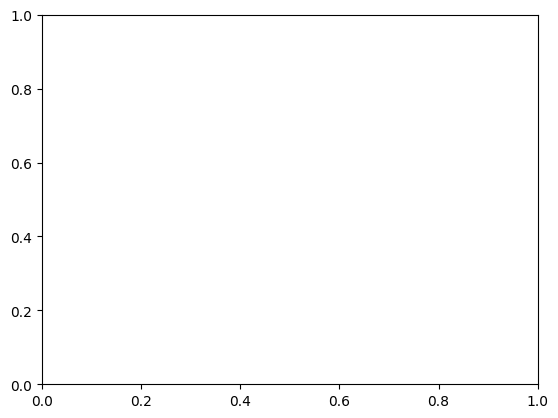

In [33]:
plt.scatter(recovery,ca_rej)
plt.scatter(recovery,so4_rej)
plt.scatter(recovery,hco3_rej)
plt.scatter(recovery,na_rej)
plt.scatter(recovery,cl_rej)
plt.legend(['Ca', 'SO4', 'HCO3', 'Na', 'Cl'])

In [ ]:
plt.scatter(recovery,arearesults,marker="o")

In [ ]:
plt.scatter(recovery,pressureresults)